In [7]:
import socket
socket.gethostname()

'calebs-skylake-ubuntu-1604'

In [8]:
import os
import sys
import numpy as np
import nept
import nelpy as nel
import matplotlib.pyplot as plt
%matplotlib inline

/home/kemerelab/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


In [9]:
dataroot = '/home/kemerelab/Data/motivational-t'

# Find all rats and days

In [10]:
from glob import glob
alldirs = glob(os.path.join(dataroot,'*/'))


In [11]:
import re 
datadirs = [re.match(r'.*(R\d\d\d-\d\d\d\d-\d\d-\d\d)', x).group(1) for x in alldirs 
     if re.match(r'.*(R\d\d\d-\d\d\d\d-\d\d-\d\d)', x)]

In [4]:
datadirs

NameError: name 'datadirs' is not defined

In [12]:
# fix annoying 'display last result only' behavior
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [39]:
# Info from ExpKeys
CONST_conv_fact = {}
CONST_conv_fact['R042'] = [2.9176, 2.3794]
CONST_conv_fact['R044'] = [2.5988, 2.4811]
CONST_conv_fact['R050'] = [2.6853, 2.6169]
CONST_conv_fact['R064'] = [2.6497, 2.6485]


In [35]:
Data = {}

In [98]:
import zipfile
import scipy.io as sio

for ddir in datadirs:
    dayinf = re.match(r'(R\d\d\d)-(\d\d\d\d-\d\d-\d\d)', ddir)
    anim = dayinf.group(1)
    day = dayinf.group(2)
    print(anim,day)
    if anim not in Data:
        Data[anim] = {}
    
    if day not in Data[anim]:
        Data[anim][day] = {}

    if 'pos' not in Data[anim][day]:
        # define some testing data file locations
        fn_vt = ddir + '-VT1.zip'
        fn_vt = os.path.join(dataroot, ddir, fn_vt)
        print(fn_vt)
        unzipped_file = None
        with zipfile.ZipFile(fn_vt,"r") as zip_ref:
            unzipped_file = zip_ref.namelist()[0]
            zip_ref.extractall("/tmp")
        if unzipped_file is not None:
            tmp_vt = os.path.join('/tmp',unzipped_file)
        else:
            warning('No position file found in archive!')
            break;

        # Load position (.nvt) from this experiment
        position = nept.load_position(tmp_vt,CONST_conv_fact[anim])

        # vt is a 2-D AnalogSignalArray -- note has bigger gaps in data b/c tracking LEDs get obscured
        vt_nelpy = np.stack((position.x,position.y),1)
        vt_nelpy = nel.AnalogSignalArray(ydata=vt_nelpy.T,timestamps=position.time,merge_sample_gap=10,fs=30)

        Data[anim][day]['pos'] = vt_nelpy

    if 'spikes' not in Data[anim][day]:
        spikes = nept.load_spikes(os.path.join(dataroot, ddir))
        spikes_list = [ss.time for ss in spikes]
        nel_spikes = nel.SpikeTrainArray(spikes_list)
        Data[anim][day]['spikes'] = nel_spikes

    if 'trial_iv' not in Data[anim][day]:
        fn_meta = ddir + '-metadata.mat'
        metadata = sio.loadmat(os.path.join(dataroot,ddir,fn_meta))
        taskvars = metadata['metadata'][0][0]['taskvars'][0][0]
        metavars = list(taskvars.dtype.fields.keys())
        iv_metavars = list(filter(lambda mv: 'iv' in mv, metavars))

        for mv in iv_metavars:
            tstart = taskvars[mv][0][0]['tstart']
            tend = taskvars[mv][0][0]['tend']
            Data[anim][day][mv] = nel.EpochArray(np.hstack([tstart, tend]))

        sequence = [choice[0] for choice in taskvars['sequence'][0]]
        Data[anim][day]['sequence'] = sequence

    if 'event-candidates' not in Data[anim][day]:
        # load ripple "candidates"
        fn_cand = ddir + '-candidates.mat'
        cand = sio.loadmat(os.path.join(dataroot,ddir,fn_cand))
        tstart = cand['evt'][0][0]['tstart']
        tend = cand['evt'][0][0]['tend']
        Data[anim][day]['event-candidates'] = nel.EpochArray(np.hstack([tstart, tend]))


R042 2013-08-16
R042 2013-08-17
R042 2013-08-18
R042 2013-08-19
R042 2013-08-20
R042 2013-08-21
R044 2013-12-18
R044 2013-12-19
R044 2013-12-20
R044 2013-12-21
R044 2013-12-22
R044 2013-12-23
R050 2014-03-29
R050 2014-03-30
R050 2014-03-31
R050 2014-04-01
R050 2014-04-02
R050 2014-04-03
R064 2015-04-18
/home/kemerelab/Data/motivational-t/R064-2015-04-18/R064-2015-04-18-VT1.zip


/home/kemerelab/Code/nelpy/nelpy/core/_analogsignalarray.py:360: UserWarning: creating support from time and sampling rate, fs!
/home/kemerelab/Code/nelpy/nelpy/utils.py:549: UserWarning: some steps in the data are smaller than the requested step size.
/home/kemerelab/Code/nelpy/nelpy/core/_spiketrain.py:532: UserWarning: No sampling rate was specified! Assuming default of 30000 Hz.


R064 2015-04-19
/home/kemerelab/Data/motivational-t/R064-2015-04-19/R064-2015-04-19-VT1.zip
R064 2015-04-20
/home/kemerelab/Data/motivational-t/R064-2015-04-20/R064-2015-04-20-VT1.zip
R064 2015-04-21
/home/kemerelab/Data/motivational-t/R064-2015-04-21/R064-2015-04-21-VT1.zip
R064 2015-04-22
/home/kemerelab/Data/motivational-t/R064-2015-04-22/R064-2015-04-22-VT1.zip
R064 2015-04-23
/home/kemerelab/Data/motivational-t/R064-2015-04-23/R064-2015-04-23-VT1.zip


In [100]:
import nelpy.io
MVDMData = nel.ResultsContainer(Data=Data,
                                    description='Motivational-T maze data all animals and sessions.\n')

In [102]:
MVDMData.save_pkl('/home/kemerelab/Data/FullMVDMData.nel')

# Figure out bounds of arms for all animals

R042 2013-08-16
R042 2013-08-17
R042 2013-08-18
R042 2013-08-19
R042 2013-08-20
R042 2013-08-21
R044 2013-12-18
R044 2013-12-19
R044 2013-12-20
R044 2013-12-21
R044 2013-12-22
R044 2013-12-23
R050 2014-03-29
R050 2014-03-30
R050 2014-03-31
R050 2014-04-01
R050 2014-04-02
R050 2014-04-03
R064 2015-04-18
R064 2015-04-19
R064 2015-04-20
R064 2015-04-21
R064 2015-04-22
R064 2015-04-23


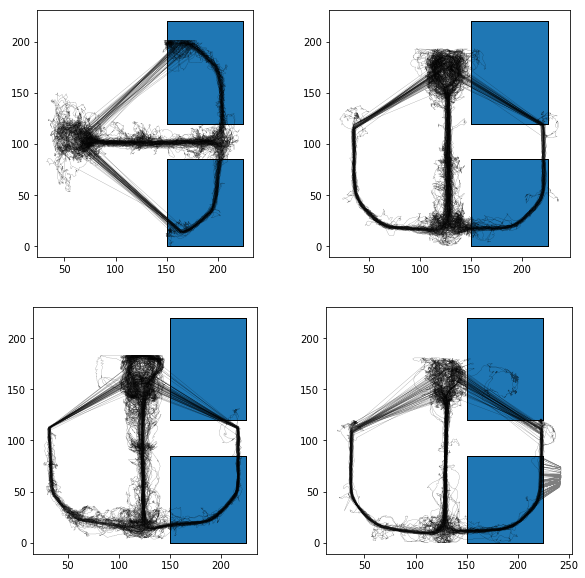

In [103]:
from shapely.geometry import box
from descartes.patch import PolygonPatch # pip install descartes
import warnings

fig, axs = plt.subplots(2,2,figsize = (10, 10))
axs = axs.flatten()

TrackData = {}
TrackData['R042'] = {}
TrackData['R042']['LeftArmRect'] = [150,120,225,220]
TrackData['R042']['RightArmRect'] = [150,0,225,85]
TrackData['R042']['XExtents'] = [25,225]
TrackData['R042']['YExtents'] = [0, 210]

TrackData['R044'] = {}
TrackData['R044']['LeftArmRect'] = [150,120,225,220]
TrackData['R044']['RightArmRect'] = [150,0,225,85]
TrackData['R044']['XExtents'] = [25,225]
TrackData['R044']['YExtents'] = [0, 210]

TrackData['R050'] = {}
TrackData['R050']['LeftArmRect'] = [150,120,225,220]
TrackData['R050']['RightArmRect'] = [150,0,225,85]
TrackData['R050']['XExtents'] = [25,225]
TrackData['R050']['YExtents'] = [0, 210]

TrackData['R064'] = {}
TrackData['R064']['LeftArmRect'] = [150,120,225,220]
TrackData['R064']['RightArmRect'] = [150,0,225,85]
TrackData['R064']['XExtents'] = [25,225]
TrackData['R064']['YExtents'] = [0, 210]

idx = 0
for anim, animdata in Data.items():
    for day, daydata in animdata.items():
        print(anim, day)
        pos = Data[anim][day]['pos']
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            runpos = pos[Data[anim][day]['trial_iv'],:]
            xvals, yvals = runpos.asarray().yvals;
    
        ax = axs[idx];
        ax.set_aspect('equal');
        _ = ax.plot(xvals, yvals, lw=0.25, color='k', alpha=0.5);

        RightArmCoords = TrackData[anim]['RightArmRect']
        b_right = box(*RightArmCoords);
        _ = ax.add_patch(PolygonPatch(b_right));

        LeftArmCoords = TrackData[anim]['LeftArmRect']
        b_left = box(*LeftArmCoords);
        _ = ax.add_patch(PolygonPatch(b_left));
        
    idx = idx + 1

In [68]:
Data['R050']['2014-03-30'].keys()

dict_keys(['pos', 'spikes', 'trial_iv', 'trial_iv_L', 'trial_iv_R', 'rest_iv', 'rest_iv_pedL', 'rest_iv_pedR', 'sequence', 'event-candidates'])

In [95]:
pos = Data['R050']['2014-03-30']['pos']

In [76]:
Data['R050']['2014-03-30']['trial_iv_L'].stops

array([ 6949.92392 ,  7289.997346,  7722.729915,  7851.625578,  8339.246452])

In [79]:
runpos = pos[Data['R050']['2014-03-30']['trial_iv_L'],:]

/home/kemerelab/Code/nelpy/nelpy/core/_analogsignalarray.py:862: UserWarning: Index resulted in empty epoch array


In [96]:
[pos.support.starts, pos.support.stops]

[array([ 4506.180203,  6019.026203]), array([ 6007.48130033,  9504.24403433])]

R064 2015-04-18
<EpochArray at 0x7f87f19075f8: 23 epochs> of duration 6:17:345 minutes
R064 2015-04-19
<EpochArray at 0x7f87f190a9e8: 21 epochs> of duration 7:42:397 minutes
R064 2015-04-20
<EpochArray at 0x7f87f191b400: 22 epochs> of duration 4:47:987 minutes
R064 2015-04-21
<EpochArray at 0x7f87f1926198: 23 epochs> of duration 6:41:670 minutes
R064 2015-04-22
<EpochArray at 0x7f87f192c630: 24 epochs> of duration 4:20:624 minutes
R064 2015-04-23
<EpochArray at 0x7f87f1934e48: 21 epochs> of duration 5:59:827 minutes


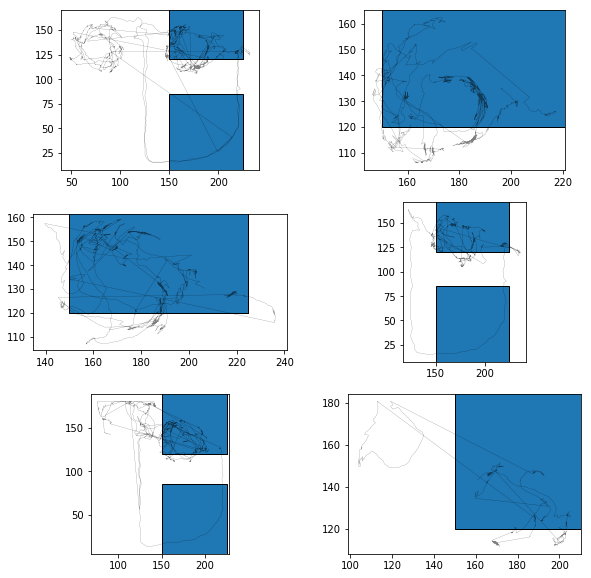

In [65]:
fig, axs = plt.subplots(3,2,figsize = (10, 10))
axs = axs.flatten()
idx = 0
for day, daydata in Data['R064'].items():
    print(anim, day)
    
    print(Data[anim][day]['trial_iv'])
    pos = Data[anim][day]['pos']

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        runpos = pos[Data[anim][day]['trial_iv_L'],:]
        xvals, yvals = runpos.asarray().yvals;

    ax = axs[idx];
    ax.set_aspect('equal');
    _ = ax.plot(xvals, yvals, lw=0.25, color='k', alpha=0.5);

    RightArmCoords = TrackData[anim]['RightArmRect']
    b_right = box(*RightArmCoords);
    _ = ax.add_patch(PolygonPatch(b_right));

    LeftArmCoords = TrackData[anim]['LeftArmRect']
    b_left = box(*LeftArmCoords);
    _ = ax.add_patch(PolygonPatch(b_left));
    
    idx = idx + 1

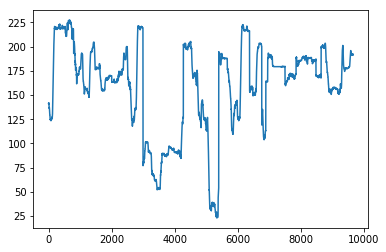

In [61]:
plt.plot(xvals)

In [ ]:
import nelpy.io
MVDMData = nel.ResultsContainer(Data=Data,
                                    description='Motivational-T maze data all animals and sessions.\n')

In [ ]:
MVDMData.save_pkl('/home/kemerelab/Data/MVDMData.nel')